In [71]:
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K


# def add_decorate(x):
#     """
#     axis = -1 --> last dimension in an array
#     """
#     m = K.mean(x, axis=-1, keepdims=True)
#     d = K.square(x - m)
#     return K.concatenate([x, d], axis=-1)


# def add_decorate_shape(input_shape):
#     shape = list(input_shape)
#     assert len(shape) == 2
#     shape[1] *= 2
#     return tuple(shape)

# model.add(Lambda(antirectifier, output_shape=antirectifier_output_shape))


lr = 2e-4  # 0.0002
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)


def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G

        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
#         D.add(Lambda(add_decorate, output_shape=None, input_shape=(ni_D,))) 
        D.add(Dense(50, activation='relu', input_shape=(ni_D,)))
        # np.shape(100) == np.shape(100,)과 같은것. 그냥 문법적인 인정을 하고 넘어가자
        # y = np.zeros((2, 3, 4)) 과 y.shape = (24,) 를 프린트해보자.
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))

        model_compile(D)
        return D

    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_D

        G = models.Sequential()  # (Batch, ni_D)
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))  # (Batch, steps=ni_D, input_dim=1)
        G.add(Conv1D(nh_G, 1, activation='relu'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(1, 1))  # (Batch, ni_D, 1)
        G.add(Flatten())  # (Batch, ni_D)

        model_compile(G)
        return G

    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD

    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)


class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)


class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 1
        self.n_iter_G = 5

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)

        self.n_batch = n_batch
        # self.ni_D = ni_D

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        # Real data
        Real = data.real_sample(n_batch)  # (n_batch, ni_D)
        # print(Real.shape)
        # Generated data
        Z = data.in_sample(n_batch)  # (n_batch, ni_D)
        Gen = gan.G.predict(Z)  # (n_batch, ni_D)
        # print(Gen.shape)

        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data for data generation
        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        gan.GD_train_on_batch(Z)

    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()

    def test(self, n_test):
        """
        generate a new image
        """
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        """
        train GAN and show the results
        for showing, the original and the artificial results will be compared
        """
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))


# class GAN_Pure(GAN):
#     def __init__(self, ni_D, nh_D, nh_G):
#         '''
#         Discriminator input is not added
#         '''
#         super().__init__(ni_D, nh_D, nh_G)

#     def gen_D(self):
#         ni_D = self.ni_D
#         nh_D = self.nh_D
#         D = models.Sequential()
#         # D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
#         D.add(Dense(nh_D, activation='relu', input_shape=(ni_D,)))
#         D.add(Dense(nh_D, activation='relu'))
#         D.add(Dense(1, activation='sigmoid'))

#         model_compile(D)
#         return D


# class Machine_Pure(Machine):
#     def __init__(self, n_batch=10, ni_D=100):
#         data_mean = 4
#         data_stddev = 1.25

#         self.data = Data(data_mean, data_stddev, ni_D)
#         self.gan = GAN_Pure(ni_D=ni_D, nh_D=50, nh_G=50)

#         self.n_batch = n_batch
#         # self.ni_D = ni_D


def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=200, n_show=200, n_test=100)

Stage 0 (Epoch: 0)
Mean and Std of Real: (4.006750554208507, 1.2396085956974363)
Mean and Std of Gen: (2.8189304, 1.0479994)


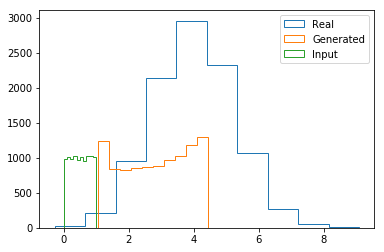

Stage 1 (Epoch: 200)
Mean and Std of Real: (3.990436210810669, 1.2612697091601381)
Mean and Std of Gen: (4.7123485, 1.5219492)


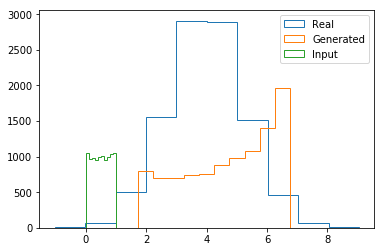

Stage 2 (Epoch: 400)
Mean and Std of Real: (3.9846481290742597, 1.2565533149911416)
Mean and Std of Gen: (4.775486, 1.4749194)


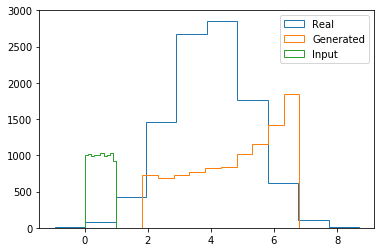

Stage 3 (Epoch: 600)
Mean and Std of Real: (4.015129396391796, 1.2506868823187107)
Mean and Std of Gen: (4.0527678, 1.3832784)


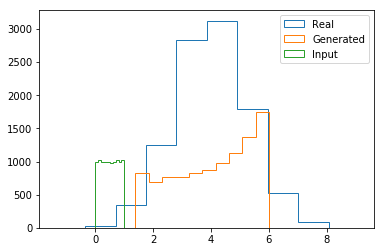

Stage 4 (Epoch: 800)
Mean and Std of Real: (3.9926045121246854, 1.236967743539648)
Mean and Std of Gen: (4.485886, 1.1694114)


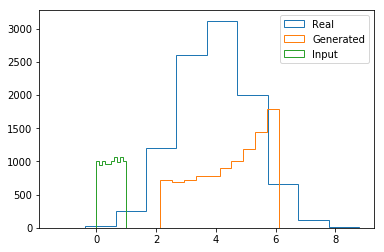

Stage 5 (Epoch: 1000)
Mean and Std of Real: (3.9891845213205497, 1.2486857409560903)
Mean and Std of Gen: (4.1154847, 1.4703882)


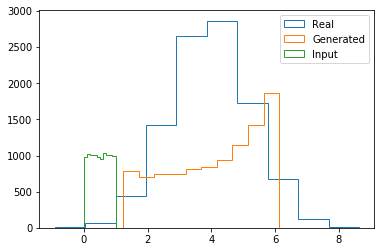

Stage 6 (Epoch: 1200)
Mean and Std of Real: (4.034105949956319, 1.252885104504013)
Mean and Std of Gen: (3.6918714, 1.0648929)


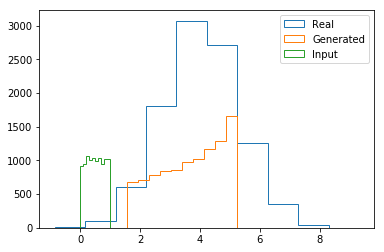

Stage 7 (Epoch: 1400)
Mean and Std of Real: (4.008388743464146, 1.2578579674873076)
Mean and Std of Gen: (4.0826106, 1.275299)


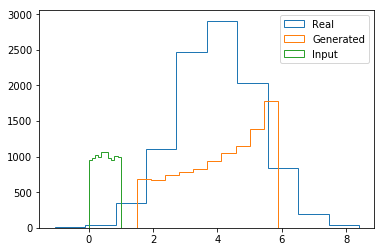

Stage 8 (Epoch: 1600)
Mean and Std of Real: (3.990425594187221, 1.250351643023856)
Mean and Std of Gen: (3.6559527, 1.3446361)


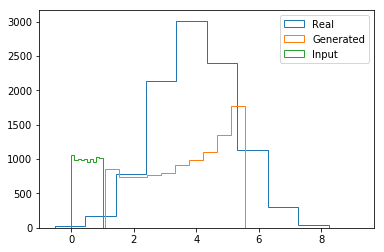

Stage 9 (Epoch: 1800)
Mean and Std of Real: (3.993301338286596, 1.2431472024642876)
Mean and Std of Gen: (3.901043, 1.0849)


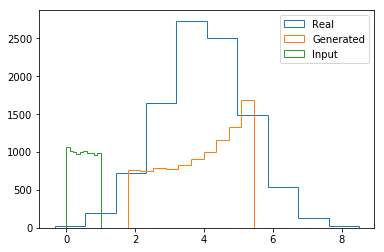

Stage 10 (Epoch: 2000)
Mean and Std of Real: (4.019719024736522, 1.2407281154775665)
Mean and Std of Gen: (3.9795012, 1.5493582)


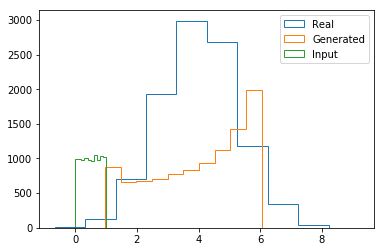

Stage 11 (Epoch: 2200)
Mean and Std of Real: (3.9870629022146344, 1.2274844555960596)
Mean and Std of Gen: (3.906819, 1.0778458)


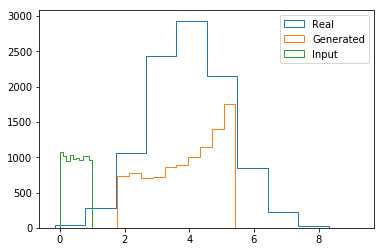

Stage 12 (Epoch: 2400)
Mean and Std of Real: (3.996878029348176, 1.2484306147685509)
Mean and Std of Gen: (4.2078557, 1.3821174)


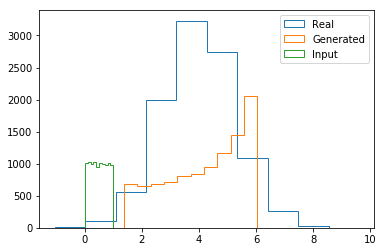

Stage 13 (Epoch: 2600)
Mean and Std of Real: (3.987125358318472, 1.2648147110707737)
Mean and Std of Gen: (3.69884, 1.1408571)


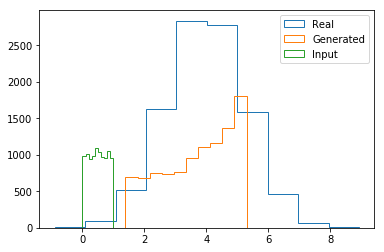

Stage 14 (Epoch: 2800)
Mean and Std of Real: (4.004199367101422, 1.2569085447136852)
Mean and Std of Gen: (3.9625785, 1.0580666)


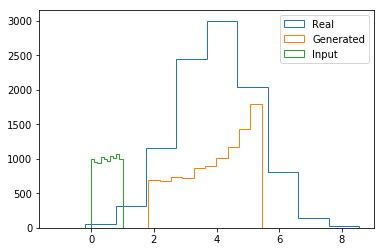

Stage 15 (Epoch: 3000)
Mean and Std of Real: (4.007202703502582, 1.2547916024062855)
Mean and Std of Gen: (3.7603476, 1.40205)


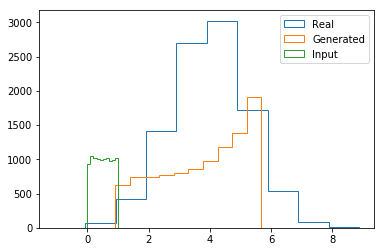

Stage 16 (Epoch: 3200)
Mean and Std of Real: (4.007073902244829, 1.243608170962936)
Mean and Std of Gen: (3.947143, 1.0528046)


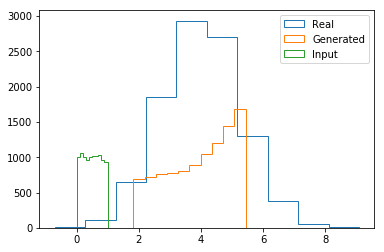

Stage 17 (Epoch: 3400)
Mean and Std of Real: (4.0185203316645834, 1.2556822736889575)
Mean and Std of Gen: (3.8752599, 1.5084985)


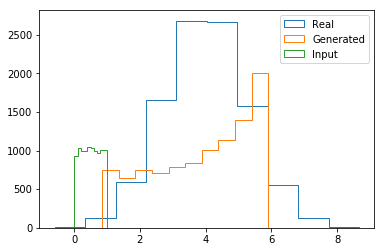

Stage 18 (Epoch: 3600)
Mean and Std of Real: (3.9713657845247248, 1.2547721953345907)
Mean and Std of Gen: (4.055528, 1.0719987)


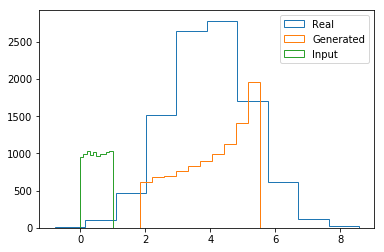

Stage 19 (Epoch: 3800)
Mean and Std of Real: (4.008442637156114, 1.2697134327890434)
Mean and Std of Gen: (4.129727, 1.1947377)


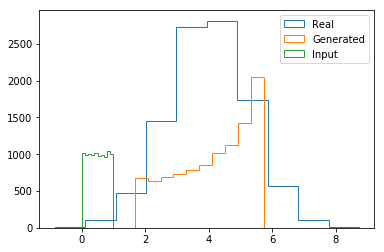

Stage 20 (Epoch: 4000)
Mean and Std of Real: (4.001496118588584, 1.2458131354020328)
Mean and Std of Gen: (3.9665716, 1.2967641)


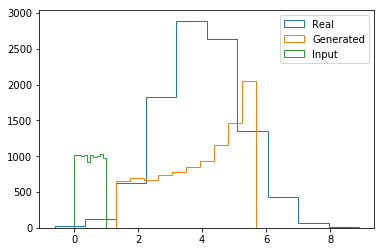

Stage 21 (Epoch: 4200)
Mean and Std of Real: (3.9830248111857784, 1.2481200223275288)
Mean and Std of Gen: (4.226029, 1.1374532)


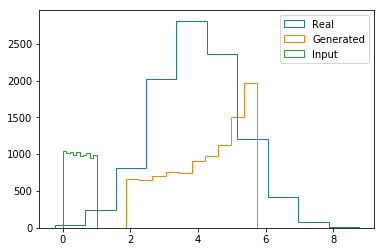

Stage 22 (Epoch: 4400)
Mean and Std of Real: (4.009513770915297, 1.250365453331984)
Mean and Std of Gen: (4.008754, 1.3669574)


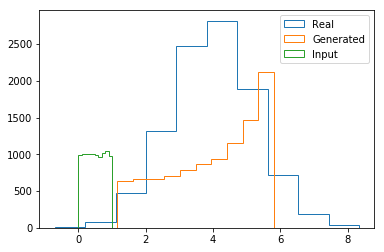

Stage 23 (Epoch: 4600)
Mean and Std of Real: (4.015321469878082, 1.2492727110631872)
Mean and Std of Gen: (3.8252313, 1.1307814)


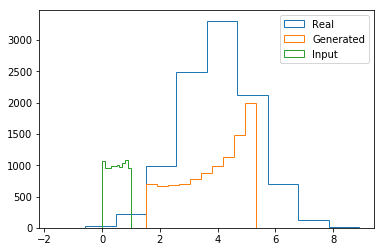

Stage 24 (Epoch: 4800)
Mean and Std of Real: (3.998972240733329, 1.2607798811982547)
Mean and Std of Gen: (4.393934, 1.2875211)


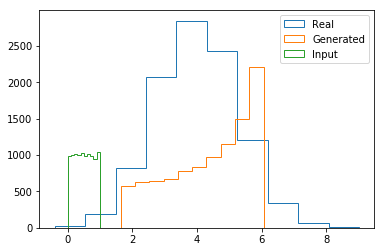

Stage 25 (Epoch: 5000)
Mean and Std of Real: (3.9874097554183523, 1.2442200391015235)
Mean and Std of Gen: (4.0705833, 1.0869617)


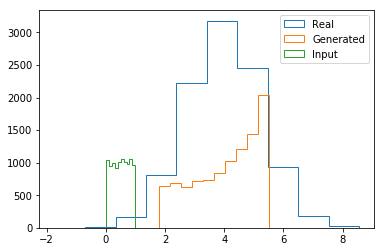

Stage 26 (Epoch: 5200)
Mean and Std of Real: (3.9974398822043686, 1.2466438208878479)
Mean and Std of Gen: (4.133251, 1.3414717)


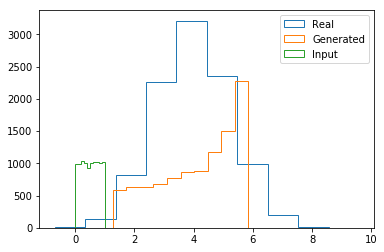

Stage 27 (Epoch: 5400)
Mean and Std of Real: (4.029467585253799, 1.2583046227607195)
Mean and Std of Gen: (4.026556, 1.1797771)


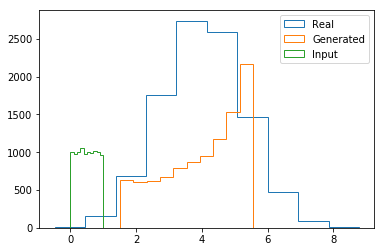

Stage 28 (Epoch: 5600)
Mean and Std of Real: (4.021711069898249, 1.2595705451120556)
Mean and Std of Gen: (4.1159153, 1.289104)


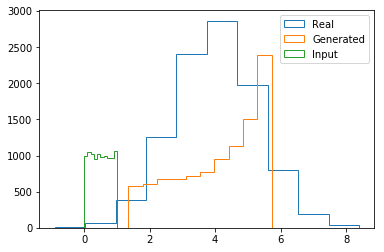

Stage 29 (Epoch: 5800)
Mean and Std of Real: (3.9974847456926814, 1.2539847225508085)
Mean and Std of Gen: (4.442549, 1.3194836)


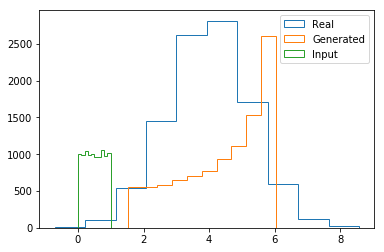

Stage 30 (Epoch: 6000)
Mean and Std of Real: (3.998932530841035, 1.2450949710659092)
Mean and Std of Gen: (3.694407, 1.237152)


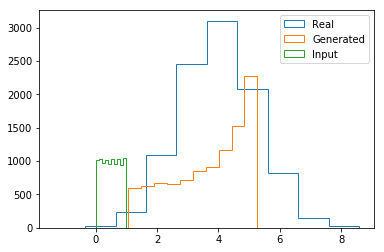

Stage 31 (Epoch: 6200)
Mean and Std of Real: (3.994378478580872, 1.2494183148635947)
Mean and Std of Gen: (3.728263, 1.0843626)


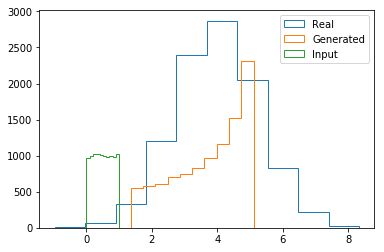

Stage 32 (Epoch: 6400)
Mean and Std of Real: (4.010741147060299, 1.25173304418445)
Mean and Std of Gen: (3.7284844, 1.3207878)


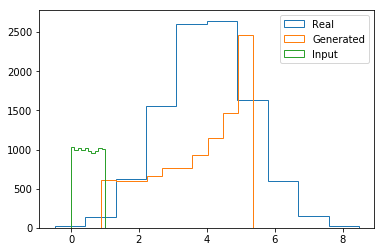

Stage 33 (Epoch: 6600)
Mean and Std of Real: (3.9966216274492115, 1.2556979983437173)
Mean and Std of Gen: (4.3819685, 1.1950415)


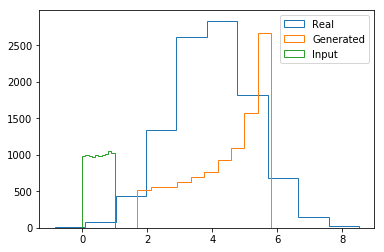

Stage 34 (Epoch: 6800)
Mean and Std of Real: (3.988284413622372, 1.2585007764377545)
Mean and Std of Gen: (3.945597, 1.1597983)


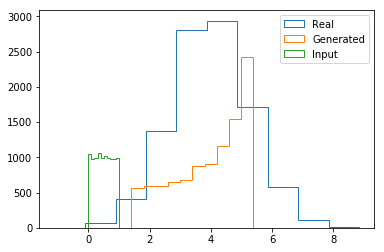

Stage 35 (Epoch: 7000)
Mean and Std of Real: (3.984065804595205, 1.2724286013352986)
Mean and Std of Gen: (3.9454007, 1.2807012)


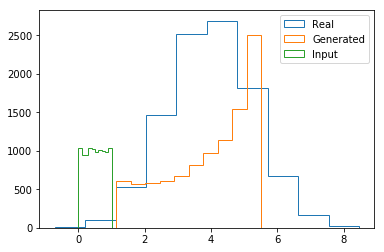

Stage 36 (Epoch: 7200)
Mean and Std of Real: (3.9994112761995044, 1.2280812942251682)
Mean and Std of Gen: (4.0041966, 1.2145715)


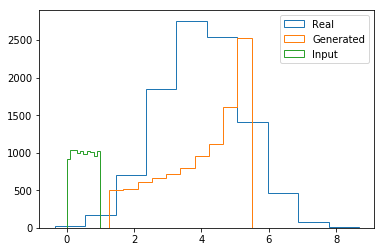

Stage 37 (Epoch: 7400)
Mean and Std of Real: (3.9775539409506675, 1.257910489749041)
Mean and Std of Gen: (3.7161336, 1.1769061)


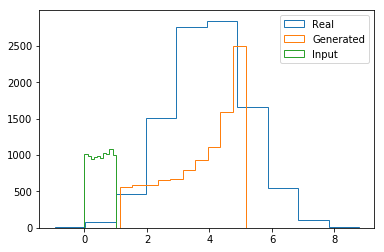

Stage 38 (Epoch: 7600)
Mean and Std of Real: (3.983064075536911, 1.2423328211023306)
Mean and Std of Gen: (4.3189383, 1.1689125)


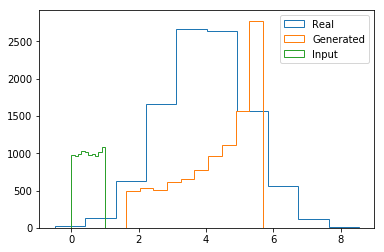

Stage 39 (Epoch: 7800)
Mean and Std of Real: (4.004676856963914, 1.2354157137491766)
Mean and Std of Gen: (3.9034743, 1.2196572)


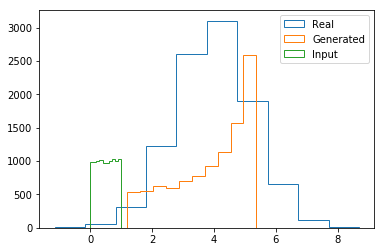

Stage 40 (Epoch: 8000)
Mean and Std of Real: (3.9952716235991232, 1.2519689973153434)
Mean and Std of Gen: (4.2064314, 1.4586928)


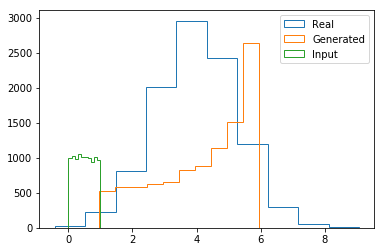

Stage 41 (Epoch: 8200)
Mean and Std of Real: (4.016245439633074, 1.2520492385156914)
Mean and Std of Gen: (3.896048, 1.3747545)


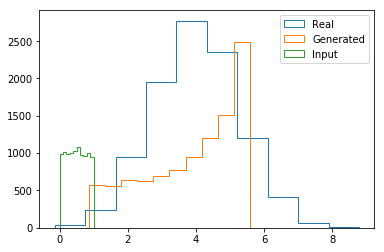

Stage 42 (Epoch: 8400)
Mean and Std of Real: (3.983114045042462, 1.2655626403889881)
Mean and Std of Gen: (3.9699082, 1.2429274)


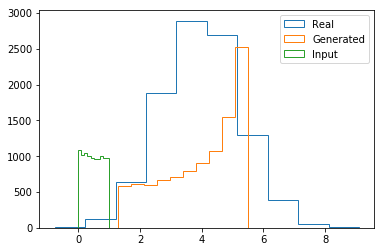

Stage 43 (Epoch: 8600)
Mean and Std of Real: (3.974209460295235, 1.240965022682817)
Mean and Std of Gen: (4.3288283, 1.2451305)


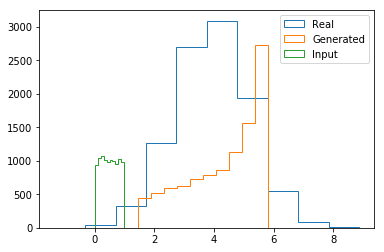

Stage 44 (Epoch: 8800)
Mean and Std of Real: (4.009240410019706, 1.2580012698480185)
Mean and Std of Gen: (4.2717714, 1.2511845)


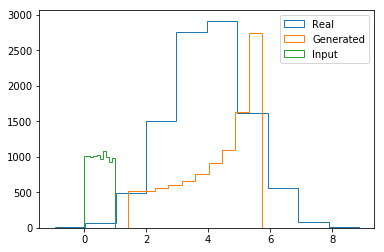

Stage 45 (Epoch: 9000)
Mean and Std of Real: (4.0355579713067184, 1.2599959899468423)
Mean and Std of Gen: (3.5858738, 1.0726303)


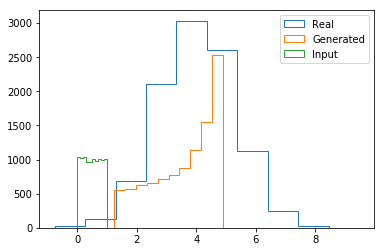

Stage 46 (Epoch: 9200)
Mean and Std of Real: (3.9974728857851756, 1.251276292111392)
Mean and Std of Gen: (4.032301, 0.9982666)


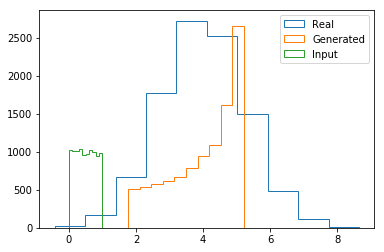

Stage 47 (Epoch: 9400)
Mean and Std of Real: (3.9888301825805224, 1.2588158663399596)
Mean and Std of Gen: (4.164503, 1.1429979)


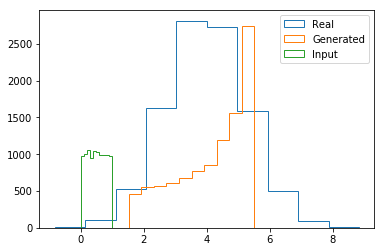

Stage 48 (Epoch: 9600)
Mean and Std of Real: (3.9915026899828967, 1.2482296272543791)
Mean and Std of Gen: (3.9647036, 1.1547345)


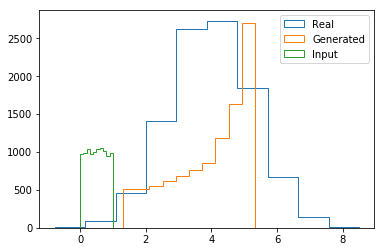

Stage 49 (Epoch: 9800)
Mean and Std of Real: (3.9957731134585273, 1.2527447484114016)
Mean and Std of Gen: (4.046123, 1.1504114)


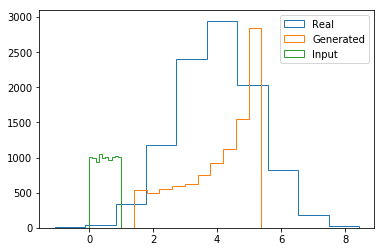

Stage 50 (Epoch: 10000)
Mean and Std of Real: (4.009727438981533, 1.2598304508180516)
Mean and Std of Gen: (3.9347675, 1.3155388)


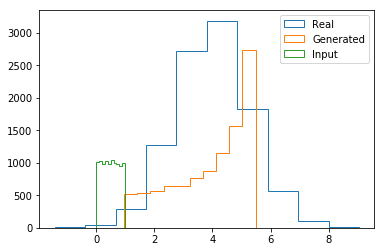

Stage 51 (Epoch: 10200)
Mean and Std of Real: (4.007943940488288, 1.2556522020970362)
Mean and Std of Gen: (3.7518063, 1.2206874)


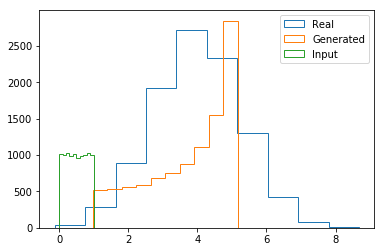

Stage 52 (Epoch: 10400)
Mean and Std of Real: (4.017970143842793, 1.2506905772064716)
Mean and Std of Gen: (3.9620266, 0.9856824)


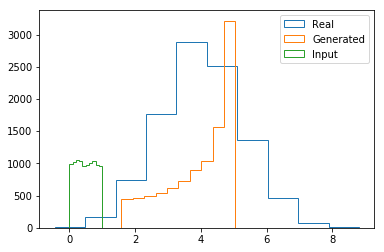

Stage 53 (Epoch: 10600)
Mean and Std of Real: (3.988742984132343, 1.2524120529948914)
Mean and Std of Gen: (3.7899477, 1.3719835)


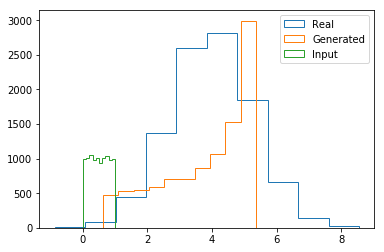

Stage 54 (Epoch: 10800)
Mean and Std of Real: (4.012435694661381, 1.2460732242709796)
Mean and Std of Gen: (4.258945, 1.2671922)


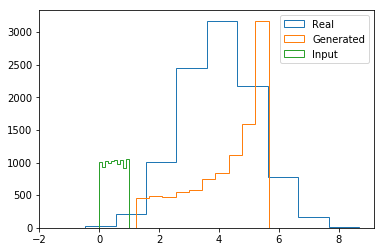

Stage 55 (Epoch: 11000)
Mean and Std of Real: (3.992953952188714, 1.2524599463688173)
Mean and Std of Gen: (4.244216, 1.3128756)


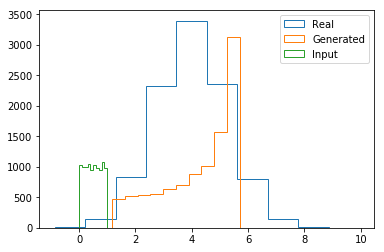

Stage 56 (Epoch: 11200)
Mean and Std of Real: (3.9755235184034223, 1.265041804703217)
Mean and Std of Gen: (4.2152777, 1.1890106)


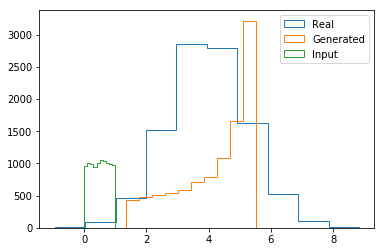

Stage 57 (Epoch: 11400)
Mean and Std of Real: (3.9908948519518717, 1.2493551054492176)
Mean and Std of Gen: (4.1047444, 1.136287)


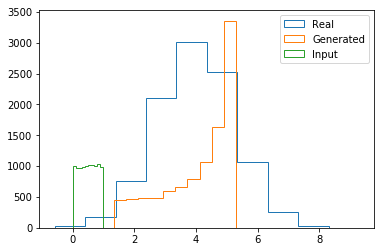

Stage 58 (Epoch: 11600)
Mean and Std of Real: (3.9798432783453985, 1.2360571703714425)
Mean and Std of Gen: (3.897939, 1.0344683)


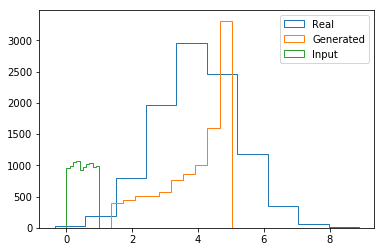

Stage 59 (Epoch: 11800)
Mean and Std of Real: (3.9994445196699955, 1.256838131028121)
Mean and Std of Gen: (4.2559204, 1.5006081)


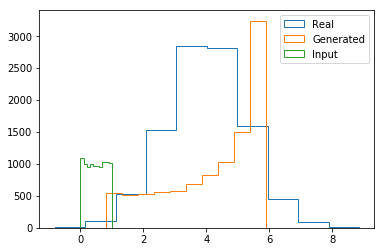

Stage 60 (Epoch: 12000)
Mean and Std of Real: (3.982438532696507, 1.238237123613932)
Mean and Std of Gen: (3.704869, 1.0452365)


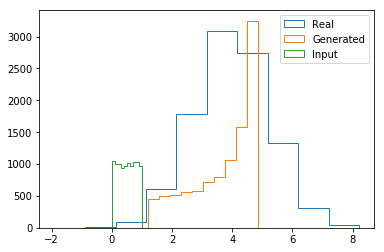

Stage 61 (Epoch: 12200)
Mean and Std of Real: (4.014210957048608, 1.2528131520994876)
Mean and Std of Gen: (3.8379703, 1.1778536)


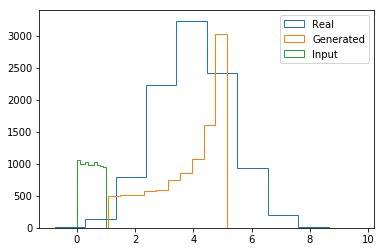

Stage 62 (Epoch: 12400)
Mean and Std of Real: (4.005802891780637, 1.253546878254032)
Mean and Std of Gen: (3.8252902, 1.4310727)


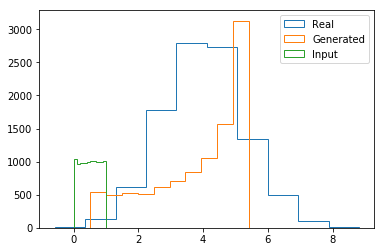

Stage 63 (Epoch: 12600)
Mean and Std of Real: (4.009777839594197, 1.2481624884298397)
Mean and Std of Gen: (4.395858, 1.5019815)


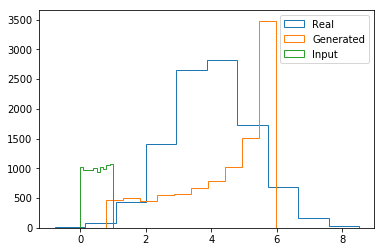

Stage 64 (Epoch: 12800)
Mean and Std of Real: (3.9817404831272842, 1.2504605066268222)
Mean and Std of Gen: (3.9414332, 1.1045015)


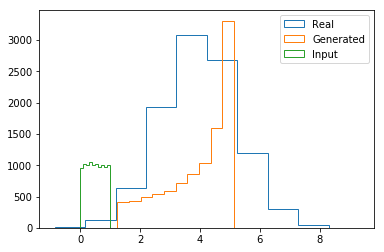

Stage 65 (Epoch: 13000)
Mean and Std of Real: (3.9933468892486963, 1.2612439113149825)
Mean and Std of Gen: (4.122929, 1.1284924)


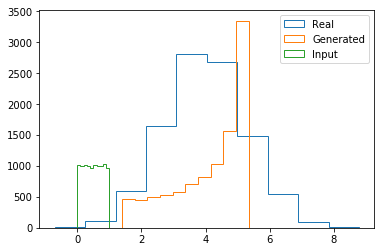

Stage 66 (Epoch: 13200)
Mean and Std of Real: (3.993533599167932, 1.2320149290289477)
Mean and Std of Gen: (3.9905624, 1.2077429)


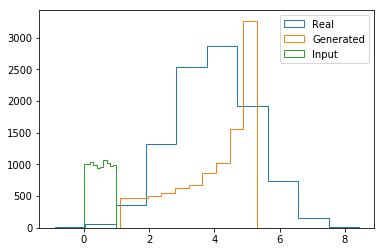

Stage 67 (Epoch: 13400)
Mean and Std of Real: (3.9771562098754716, 1.2491189442570216)
Mean and Std of Gen: (3.9216442, 1.2893118)


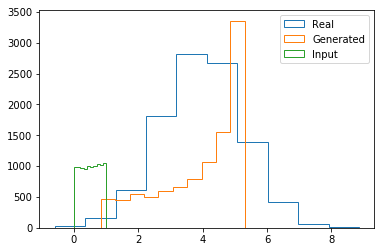

Stage 68 (Epoch: 13600)
Mean and Std of Real: (3.990297429917517, 1.252127932353848)
Mean and Std of Gen: (4.0181475, 1.1764675)


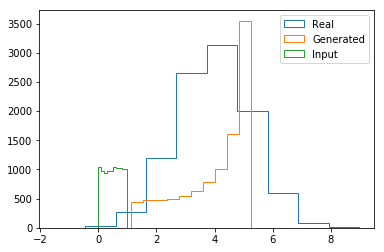

Stage 69 (Epoch: 13800)
Mean and Std of Real: (4.004867635683331, 1.256524374679364)
Mean and Std of Gen: (4.1471205, 1.375114)


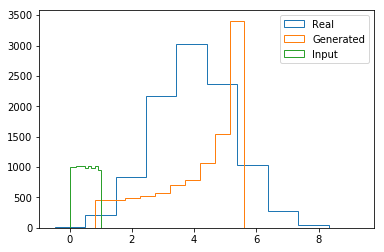

Stage 70 (Epoch: 14000)
Mean and Std of Real: (4.000453450593451, 1.2371161768048786)
Mean and Std of Gen: (3.892761, 1.2006661)


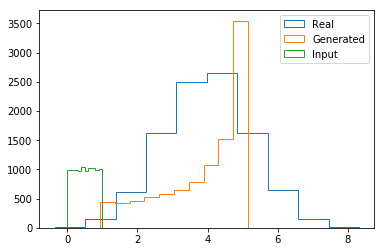

Stage 71 (Epoch: 14200)
Mean and Std of Real: (4.004317934342947, 1.237391160020439)
Mean and Std of Gen: (3.882179, 1.1965133)


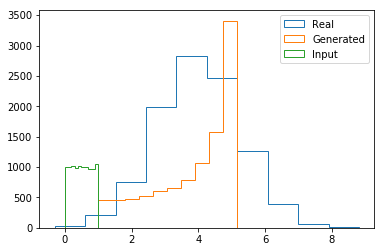

Stage 72 (Epoch: 14400)
Mean and Std of Real: (4.025625645813175, 1.2635554622010678)
Mean and Std of Gen: (4.0719705, 1.4463962)


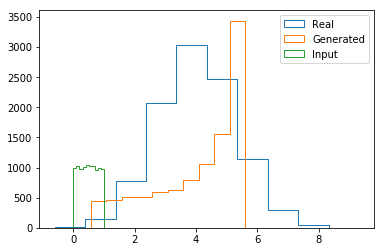

Stage 73 (Epoch: 14600)
Mean and Std of Real: (3.9841543538281767, 1.2582729344644414)
Mean and Std of Gen: (4.1678596, 1.3134605)


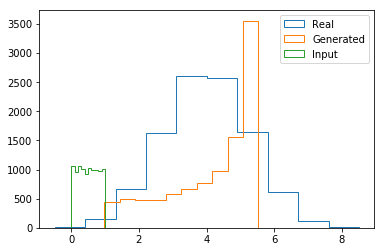

Stage 74 (Epoch: 14800)
Mean and Std of Real: (3.995541002645386, 1.2514310693101445)
Mean and Std of Gen: (4.122929, 1.1365509)


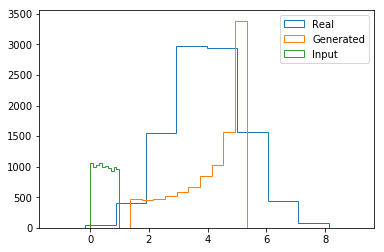

Stage 75 (Epoch: 15000)
Mean and Std of Real: (3.9803222096991697, 1.237712643100447)
Mean and Std of Gen: (3.6460738, 1.1498682)


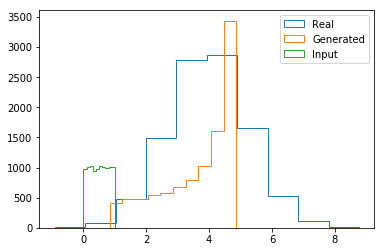

Stage 76 (Epoch: 15200)
Mean and Std of Real: (3.9744867140695415, 1.2589161490864758)
Mean and Std of Gen: (4.3102865, 1.2620934)


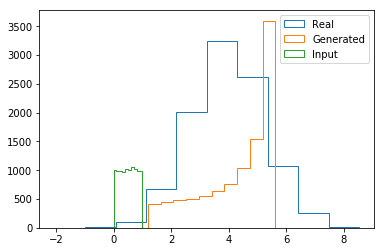

Stage 77 (Epoch: 15400)
Mean and Std of Real: (4.000810568898578, 1.2435267219591672)
Mean and Std of Gen: (3.6101296, 1.1190459)


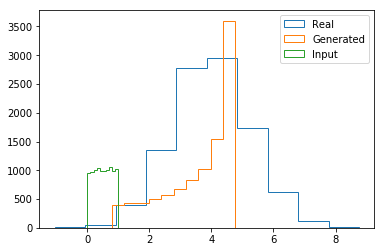

Stage 78 (Epoch: 15600)
Mean and Std of Real: (4.013220182183906, 1.2546096534265705)
Mean and Std of Gen: (4.140349, 1.2094848)


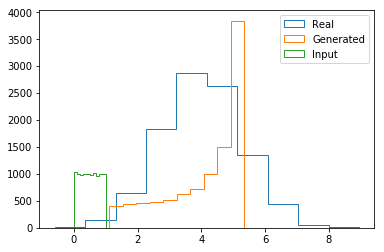

Stage 79 (Epoch: 15800)
Mean and Std of Real: (3.993849088999605, 1.22959493591587)
Mean and Std of Gen: (4.0070033, 1.4953705)


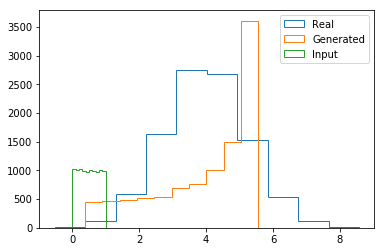

Stage 80 (Epoch: 16000)
Mean and Std of Real: (3.9911672103077014, 1.260978930970754)
Mean and Std of Gen: (4.0813217, 1.2240413)


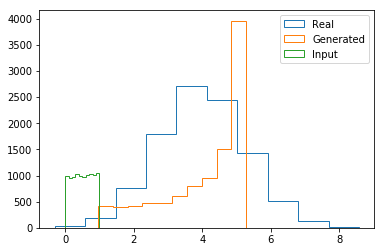

Stage 81 (Epoch: 16200)
Mean and Std of Real: (4.018400427320933, 1.2479569038059934)
Mean and Std of Gen: (4.1884904, 1.0444514)


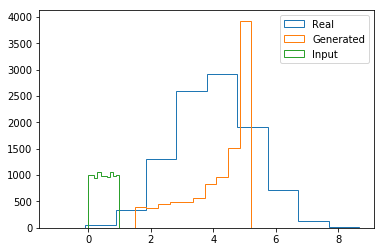

Stage 82 (Epoch: 16400)
Mean and Std of Real: (4.012050192582258, 1.2494215598182135)
Mean and Std of Gen: (4.1221843, 1.2190052)


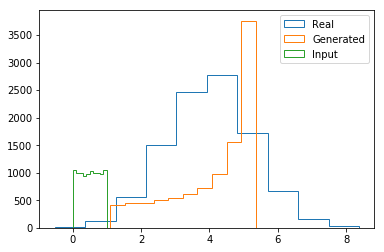

Stage 83 (Epoch: 16600)
Mean and Std of Real: (4.023377504608046, 1.2349417991108358)
Mean and Std of Gen: (3.8948207, 1.2216977)


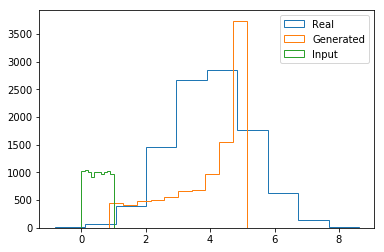

Stage 84 (Epoch: 16800)
Mean and Std of Real: (3.997276577934863, 1.2540080091952968)
Mean and Std of Gen: (4.176887, 1.1346959)


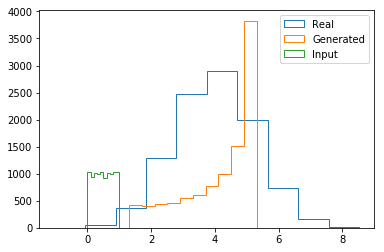

Stage 85 (Epoch: 17000)
Mean and Std of Real: (3.99860840710491, 1.2553805046788258)
Mean and Std of Gen: (4.0370197, 1.485581)


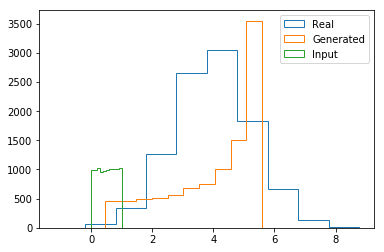

Stage 86 (Epoch: 17200)
Mean and Std of Real: (3.9977571973653685, 1.238089340356503)
Mean and Std of Gen: (3.4960577, 1.2177547)


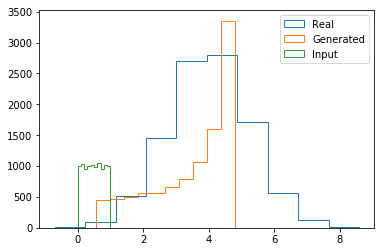

Stage 87 (Epoch: 17400)
Mean and Std of Real: (4.009675131371624, 1.2500722321729103)
Mean and Std of Gen: (4.158756, 1.1997342)


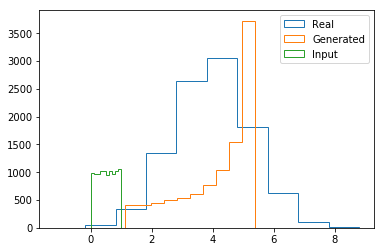

Stage 88 (Epoch: 17600)
Mean and Std of Real: (4.010718126178023, 1.2375708720379939)
Mean and Std of Gen: (3.5074668, 1.0973738)


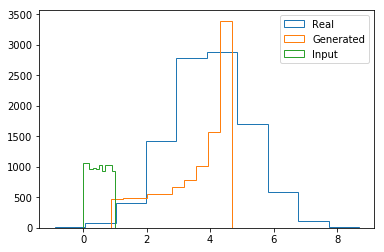

Stage 89 (Epoch: 17800)
Mean and Std of Real: (3.982656235712915, 1.2482475447195474)
Mean and Std of Gen: (3.6523228, 1.5329155)


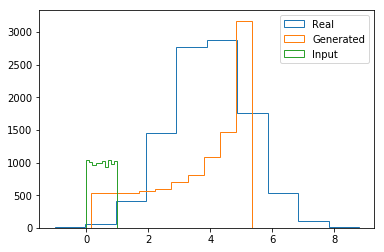

Stage 90 (Epoch: 18000)
Mean and Std of Real: (3.9911591484690363, 1.2507070671778637)
Mean and Std of Gen: (4.1560297, 1.090371)


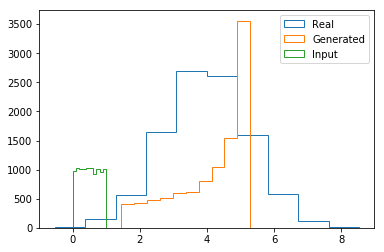

Stage 91 (Epoch: 18200)
Mean and Std of Real: (4.022210364121945, 1.2531315630817967)
Mean and Std of Gen: (3.9358523, 1.0696678)


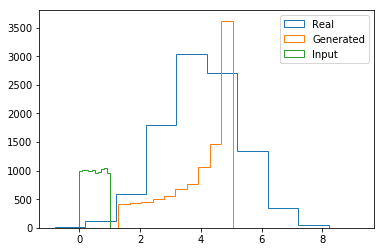

Stage 92 (Epoch: 18400)
Mean and Std of Real: (3.9935848538556864, 1.2499152980141826)
Mean and Std of Gen: (4.4172688, 1.5168732)


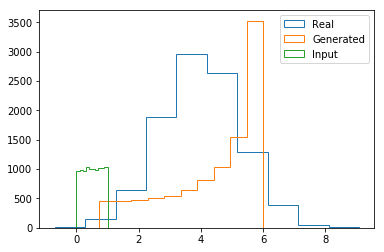

Stage 93 (Epoch: 18600)
Mean and Std of Real: (3.9825411834383724, 1.2479362805452374)
Mean and Std of Gen: (4.13409, 1.1076841)


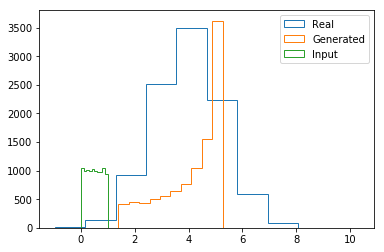

Stage 94 (Epoch: 18800)
Mean and Std of Real: (3.995101486744325, 1.250380445492799)
Mean and Std of Gen: (4.092652, 1.173821)


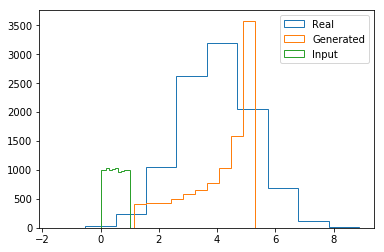

Stage 95 (Epoch: 19000)
Mean and Std of Real: (4.005881916591456, 1.253472363153069)
Mean and Std of Gen: (4.235009, 1.3792994)


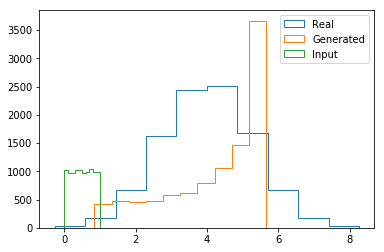

Stage 96 (Epoch: 19200)
Mean and Std of Real: (3.9981622037567286, 1.2485904092461206)
Mean and Std of Gen: (4.2014084, 1.1415247)


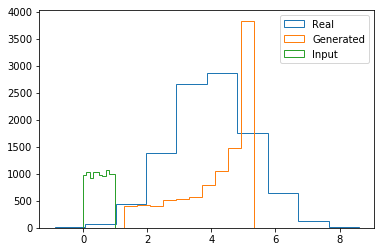

Stage 97 (Epoch: 19400)
Mean and Std of Real: (3.983060283349709, 1.2369286415738656)
Mean and Std of Gen: (4.33295, 1.2162703)


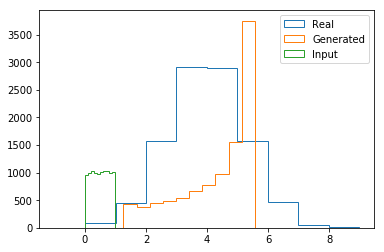

Stage 98 (Epoch: 19600)
Mean and Std of Real: (4.002337949705863, 1.2429809240724496)
Mean and Std of Gen: (4.390715, 1.4247396)


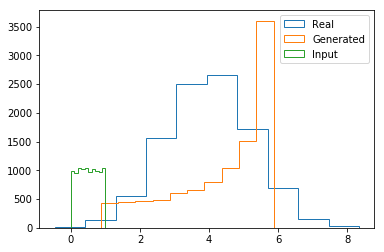

Stage 99 (Epoch: 19800)
Mean and Std of Real: (3.996164130499883, 1.2434197868997117)
Mean and Std of Gen: (4.212679, 1.3043569)


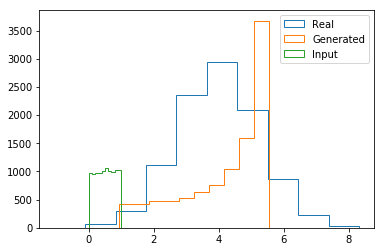

Stage 100 (Epoch: 20000)
Mean and Std of Real: (4.006031405358251, 1.2590577575681232)
Mean and Std of Gen: (3.4693735, 1.2639354)


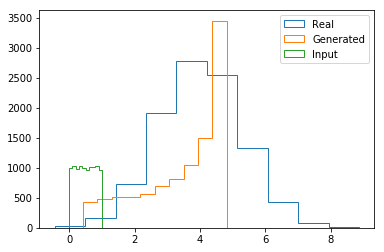

Stage 101 (Epoch: 20200)
Mean and Std of Real: (4.0081955147144175, 1.2497227291940634)
Mean and Std of Gen: (4.220752, 1.0685315)


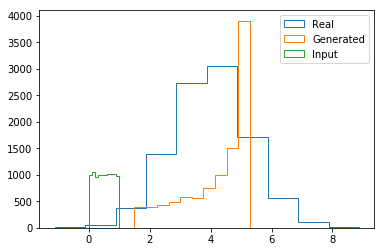

Stage 102 (Epoch: 20400)
Mean and Std of Real: (3.998070269734974, 1.2545525347957114)
Mean and Std of Gen: (3.8605063, 1.487954)


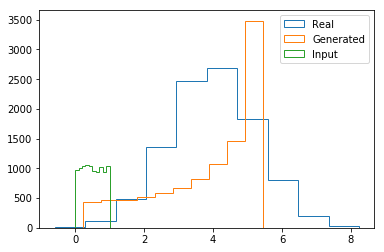

Stage 103 (Epoch: 20600)
Mean and Std of Real: (3.9789427799378085, 1.258553325407856)
Mean and Std of Gen: (4.2685885, 1.0944989)


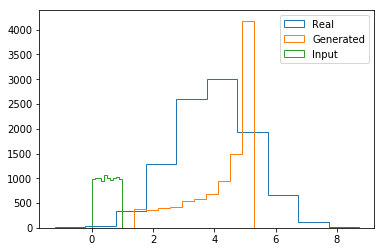

Stage 104 (Epoch: 20800)
Mean and Std of Real: (4.002053696792896, 1.2508480318960695)
Mean and Std of Gen: (4.294783, 1.0983064)


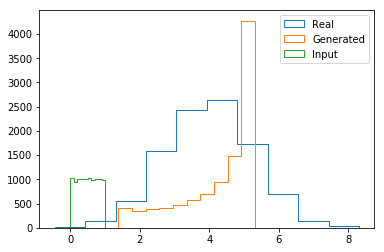

Stage 105 (Epoch: 21000)
Mean and Std of Real: (4.014348552218353, 1.2547854268860592)
Mean and Std of Gen: (3.9844003, 1.3209523)


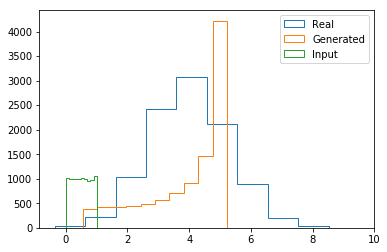

Stage 106 (Epoch: 21200)
Mean and Std of Real: (3.9717189159164454, 1.2543822956590058)
Mean and Std of Gen: (3.684263, 1.180147)


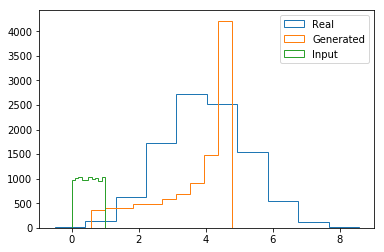

Stage 107 (Epoch: 21400)
Mean and Std of Real: (4.004926215402089, 1.241969573403111)
Mean and Std of Gen: (4.186046, 1.1594009)


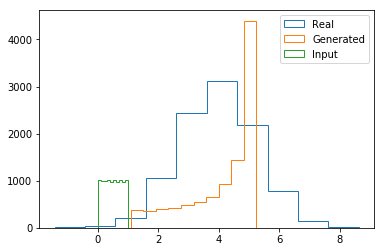

Stage 108 (Epoch: 21600)
Mean and Std of Real: (4.001748020788485, 1.244165869935183)
Mean and Std of Gen: (3.9165337, 1.294849)


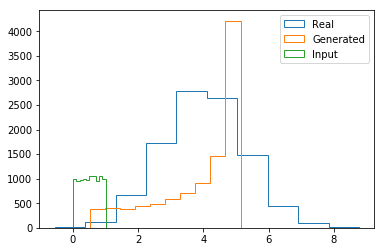

Stage 109 (Epoch: 21800)
Mean and Std of Real: (4.005482206779261, 1.2472360790185402)
Mean and Std of Gen: (4.0679593, 1.1268338)


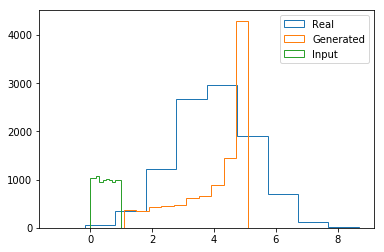

Stage 110 (Epoch: 22000)
Mean and Std of Real: (4.001869119587166, 1.2369319363207119)
Mean and Std of Gen: (3.9689813, 1.3796002)


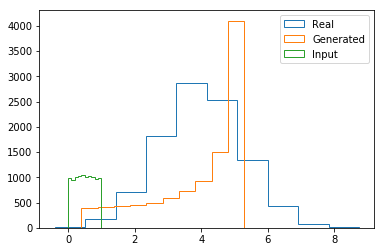

Stage 111 (Epoch: 22200)
Mean and Std of Real: (4.000265283207575, 1.26368747797797)
Mean and Std of Gen: (3.7650418, 0.9446391)


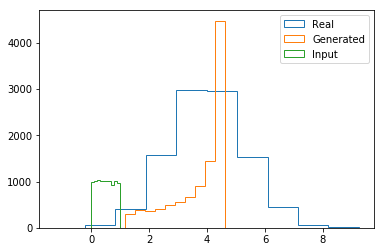

Stage 112 (Epoch: 22400)
Mean and Std of Real: (4.0151952746678, 1.2347400546192644)
Mean and Std of Gen: (3.7192757, 1.3220608)


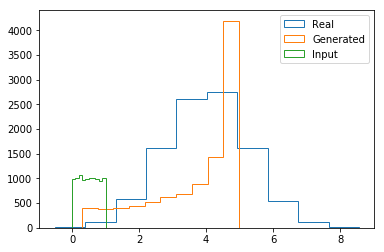

Stage 113 (Epoch: 22600)
Mean and Std of Real: (4.0041194263393844, 1.248421151592937)
Mean and Std of Gen: (3.9147184, 1.2184008)


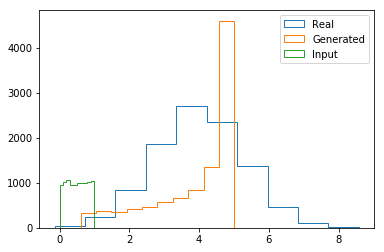

Stage 114 (Epoch: 22800)
Mean and Std of Real: (3.999470989832765, 1.2413610193013316)
Mean and Std of Gen: (3.9765134, 0.98478496)


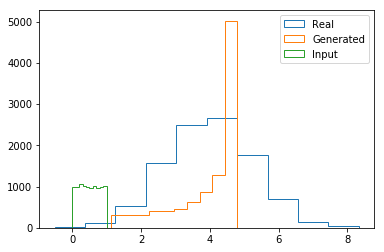

Stage 115 (Epoch: 23000)
Mean and Std of Real: (3.9999769845368434, 1.2456788238860028)
Mean and Std of Gen: (4.227314, 1.4454198)


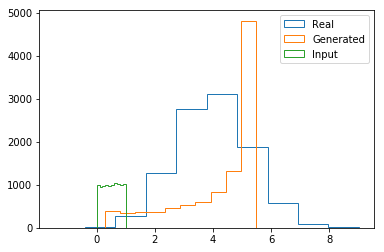

Stage 116 (Epoch: 23200)
Mean and Std of Real: (4.001439204430939, 1.253048680997179)
Mean and Std of Gen: (4.288342, 1.1850194)


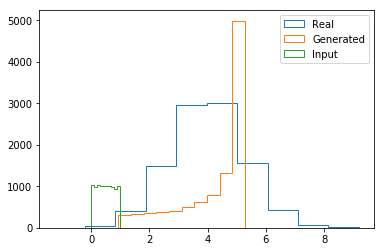

Stage 117 (Epoch: 23400)
Mean and Std of Real: (3.9905241013228974, 1.2398699303159326)
Mean and Std of Gen: (3.8852673, 1.3433172)


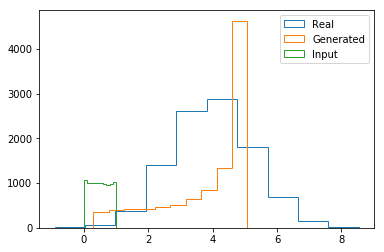

Stage 118 (Epoch: 23600)
Mean and Std of Real: (3.988174806579678, 1.2486029745964133)
Mean and Std of Gen: (4.0049896, 1.106793)


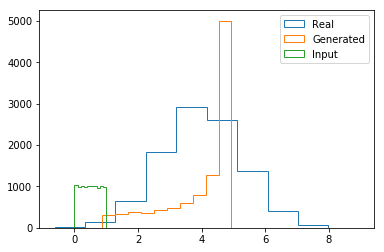

Stage 119 (Epoch: 23800)
Mean and Std of Real: (4.001811126416783, 1.2605131934629072)
Mean and Std of Gen: (3.9475796, 1.404532)


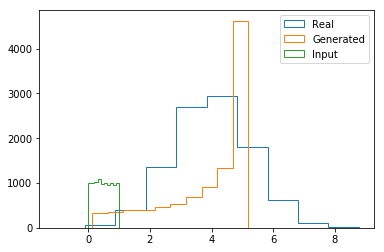

Stage 120 (Epoch: 24000)
Mean and Std of Real: (3.9958502664018947, 1.2228721462826744)
Mean and Std of Gen: (3.6249723, 1.1953495)


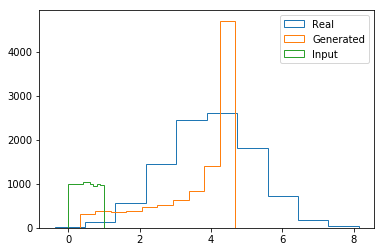

Stage 121 (Epoch: 24200)
Mean and Std of Real: (3.9861739809982706, 1.2321877370210315)
Mean and Std of Gen: (4.3669715, 1.28949)


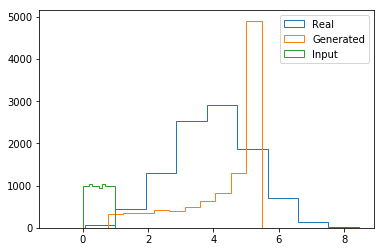

Stage 122 (Epoch: 24400)
Mean and Std of Real: (3.9963211732807546, 1.2504828573455808)
Mean and Std of Gen: (4.038179, 1.1275854)


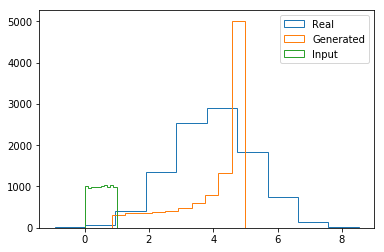

Stage 123 (Epoch: 24600)
Mean and Std of Real: (4.000119035179175, 1.238282017410908)
Mean and Std of Gen: (4.2139587, 1.329946)


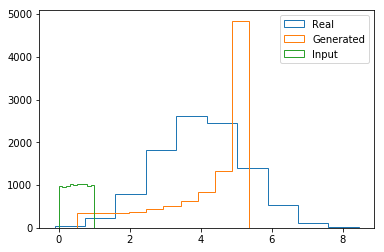

Stage 124 (Epoch: 24800)
Mean and Std of Real: (4.014421600259478, 1.24953719765737)
Mean and Std of Gen: (3.8224492, 0.8852628)


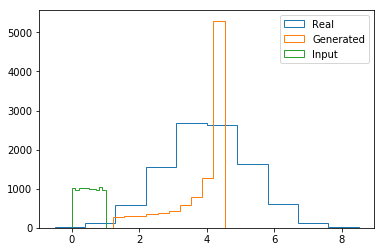

Stage 125 (Epoch: 25000)
Mean and Std of Real: (4.008253604144755, 1.2525483091271918)
Mean and Std of Gen: (4.2254367, 1.551642)


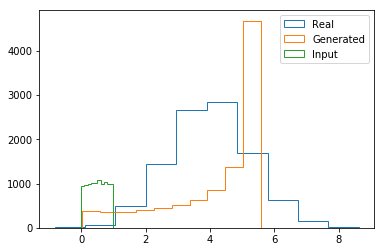

Stage 126 (Epoch: 25200)
Mean and Std of Real: (3.97573533544522, 1.2403443875061981)
Mean and Std of Gen: (3.6547976, 0.9920831)


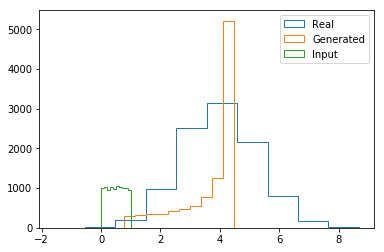

Stage 127 (Epoch: 25400)
Mean and Std of Real: (4.01338816365202, 1.2559266945407386)
Mean and Std of Gen: (3.549248, 1.2293184)


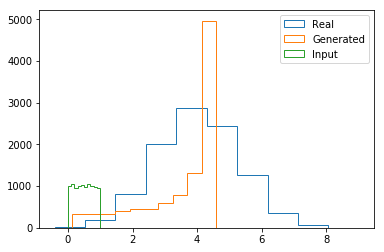

Stage 128 (Epoch: 25600)
Mean and Std of Real: (4.011015247552706, 1.2469999648555121)
Mean and Std of Gen: (3.4812672, 1.2355971)


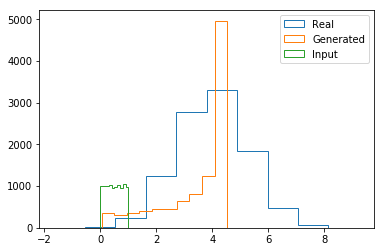

Stage 129 (Epoch: 25800)
Mean and Std of Real: (4.009144432281949, 1.2513919364917994)
Mean and Std of Gen: (3.9814727, 1.0816901)


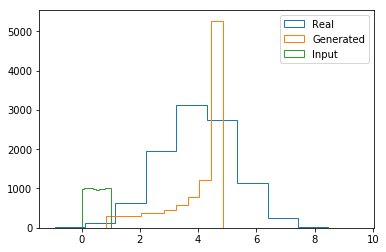

Stage 130 (Epoch: 26000)
Mean and Std of Real: (4.01507795945602, 1.2477736376384752)
Mean and Std of Gen: (4.1086907, 1.5496769)


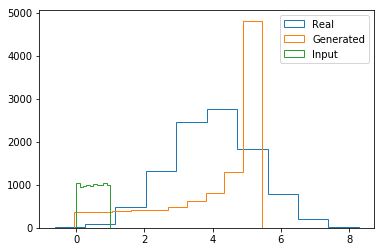

Stage 131 (Epoch: 26200)
Mean and Std of Real: (4.000093424453663, 1.245172087102879)
Mean and Std of Gen: (4.0792136, 1.0102078)


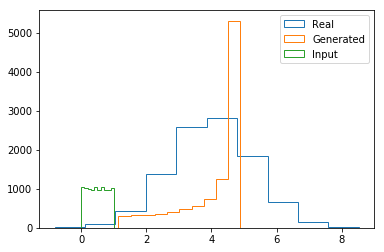

Stage 132 (Epoch: 26400)
Mean and Std of Real: (3.991962578947989, 1.23888353462578)
Mean and Std of Gen: (3.9474866, 1.0475452)


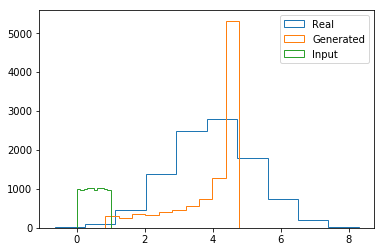

Stage 133 (Epoch: 26600)
Mean and Std of Real: (4.015878675770031, 1.2555342014677222)
Mean and Std of Gen: (4.3592544, 1.3384941)


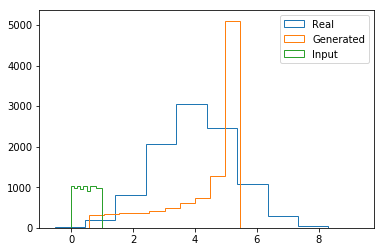

Stage 134 (Epoch: 26800)
Mean and Std of Real: (4.009132428807438, 1.244599637368541)
Mean and Std of Gen: (3.8425758, 0.9328628)


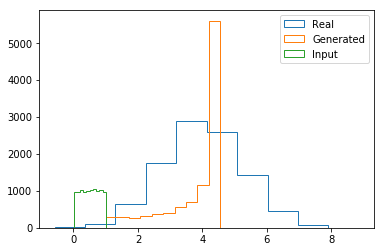

Stage 135 (Epoch: 27000)
Mean and Std of Real: (4.001966019589504, 1.2423395982154817)
Mean and Std of Gen: (4.4377675, 1.2910365)


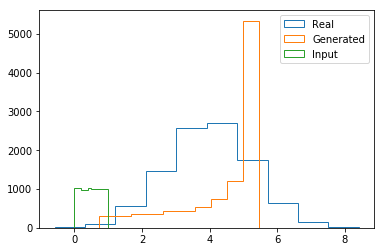

Stage 136 (Epoch: 27200)
Mean and Std of Real: (4.0155304263353075, 1.2686703769044836)
Mean and Std of Gen: (3.8308191, 1.1865581)


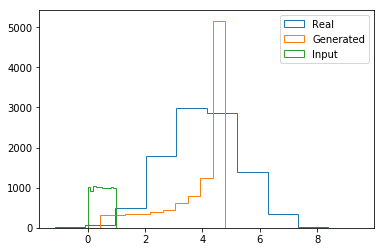

Stage 137 (Epoch: 27400)
Mean and Std of Real: (4.02308450471967, 1.2507591426378377)
Mean and Std of Gen: (3.992658, 1.1341374)


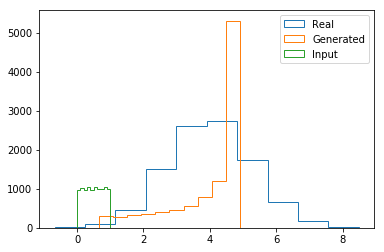

Stage 138 (Epoch: 27600)
Mean and Std of Real: (3.975531855877149, 1.2494842743519454)
Mean and Std of Gen: (4.477285, 1.4200486)


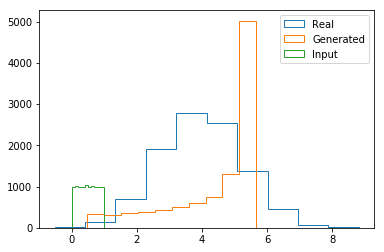

Stage 139 (Epoch: 27800)
Mean and Std of Real: (3.9914372295505287, 1.2682327880973274)
Mean and Std of Gen: (4.25424, 1.1115377)


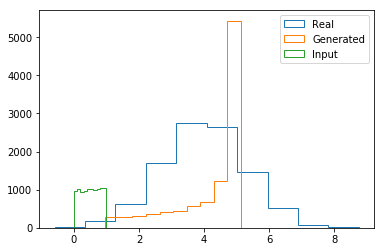

Stage 140 (Epoch: 28000)
Mean and Std of Real: (4.026637243821158, 1.258370299105795)
Mean and Std of Gen: (4.1772237, 1.2457753)


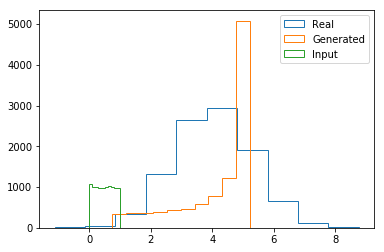

Stage 141 (Epoch: 28200)
Mean and Std of Real: (3.9949136134358234, 1.2463491748726852)
Mean and Std of Gen: (4.074883, 1.3017038)


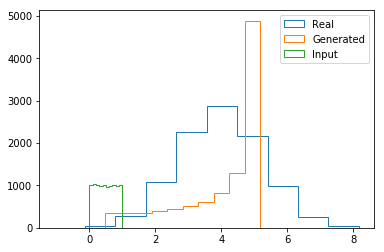

Stage 142 (Epoch: 28400)
Mean and Std of Real: (3.998261137763734, 1.240831919589588)
Mean and Std of Gen: (3.9051168, 1.3254049)


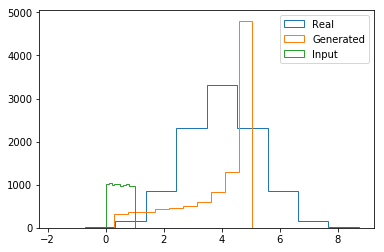

Stage 143 (Epoch: 28600)
Mean and Std of Real: (3.991243714215617, 1.2520187142776127)
Mean and Std of Gen: (4.098575, 1.1505486)


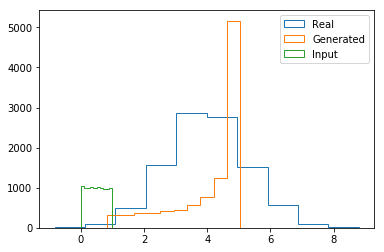

Stage 144 (Epoch: 28800)
Mean and Std of Real: (4.000615235692744, 1.2496321176575096)
Mean and Std of Gen: (3.4574034, 1.6603022)


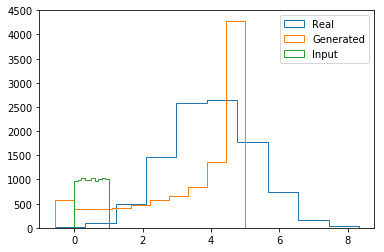

Stage 145 (Epoch: 29000)
Mean and Std of Real: (3.99699753218672, 1.2483599774279752)
Mean and Std of Gen: (3.886647, 0.8426509)


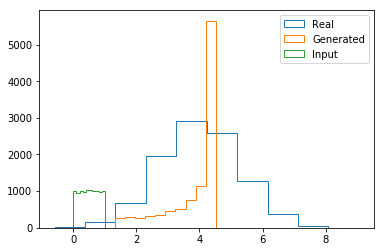

Stage 146 (Epoch: 29200)
Mean and Std of Real: (3.999260718737683, 1.253709786656888)
Mean and Std of Gen: (3.7411199, 1.0581125)


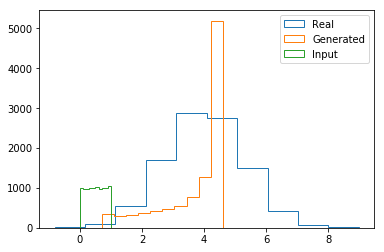

Stage 147 (Epoch: 29400)
Mean and Std of Real: (3.9922663954832154, 1.2483375661316929)
Mean and Std of Gen: (4.4722576, 1.1709957)


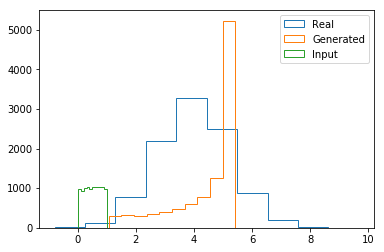

Stage 148 (Epoch: 29600)
Mean and Std of Real: (3.9782533293403453, 1.2631542707320775)
Mean and Std of Gen: (3.9936414, 1.3212115)


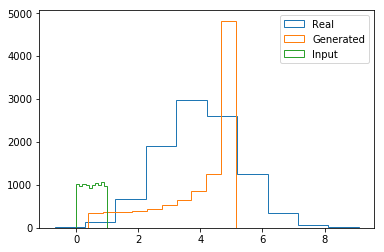

Stage 149 (Epoch: 29800)
Mean and Std of Real: (3.9994577332943053, 1.2347806557331642)
Mean and Std of Gen: (3.6098406, 1.2249128)


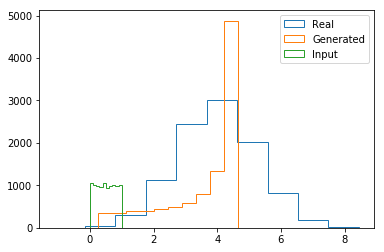

Stage 150 (Epoch: 30000)
Mean and Std of Real: (4.003407353982877, 1.257472958371402)
Mean and Std of Gen: (3.9282742, 1.2436811)


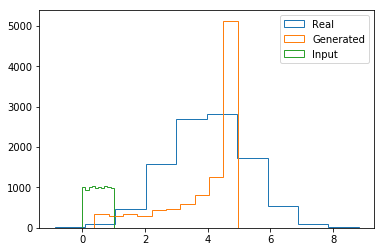

Stage 151 (Epoch: 30200)
Mean and Std of Real: (3.9938971479409497, 1.2445843083928652)
Mean and Std of Gen: (4.1130633, 1.2831694)


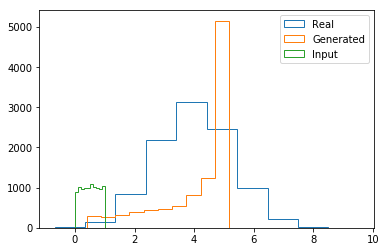

Stage 152 (Epoch: 30400)
Mean and Std of Real: (3.985637470471617, 1.2380614586760692)
Mean and Std of Gen: (3.3487976, 1.3232888)


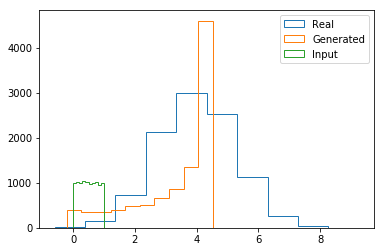

Stage 153 (Epoch: 30600)
Mean and Std of Real: (3.990241011520559, 1.2435562917526573)
Mean and Std of Gen: (3.3495762, 1.0506985)


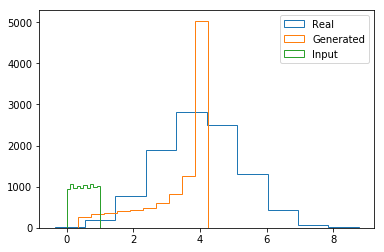

Stage 154 (Epoch: 30800)
Mean and Std of Real: (4.0077297062934925, 1.2326648506894422)
Mean and Std of Gen: (3.9898887, 1.4740192)


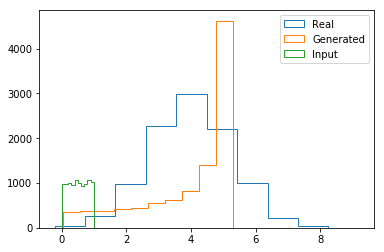

Stage 155 (Epoch: 31000)
Mean and Std of Real: (3.9714844641326863, 1.2400565401799915)
Mean and Std of Gen: (3.4888296, 1.4093964)


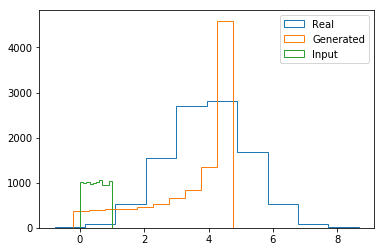

Stage 156 (Epoch: 31200)
Mean and Std of Real: (4.0084002597470905, 1.2691549142368324)
Mean and Std of Gen: (3.7349484, 0.91664904)


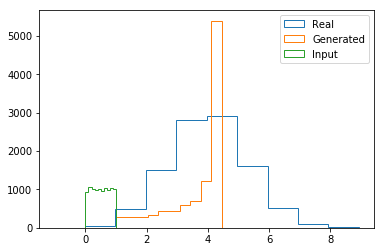

Stage 157 (Epoch: 31400)
Mean and Std of Real: (3.998207197316326, 1.2342242662394278)
Mean and Std of Gen: (3.623111, 1.5385096)


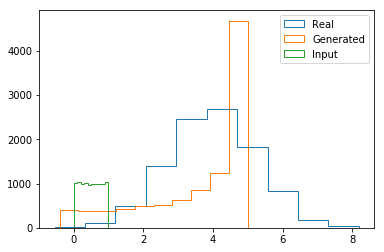

Stage 158 (Epoch: 31600)
Mean and Std of Real: (4.002465721865324, 1.2595463473677524)
Mean and Std of Gen: (3.709064, 1.2715816)


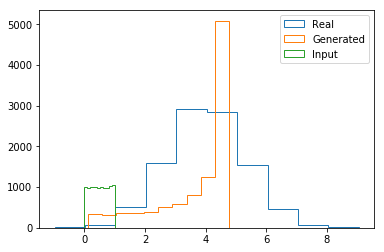

Stage 159 (Epoch: 31800)
Mean and Std of Real: (3.996827176353318, 1.2568393193937948)
Mean and Std of Gen: (3.4061704, 1.4748174)


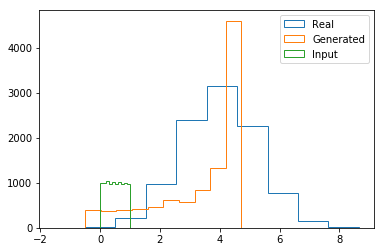

Stage 160 (Epoch: 32000)
Mean and Std of Real: (3.988234230538921, 1.2517864680305892)
Mean and Std of Gen: (3.9045093, 1.1757147)


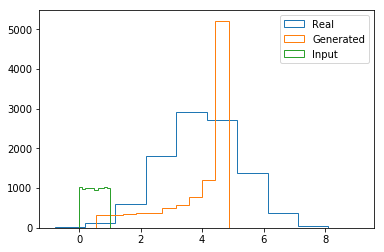

Stage 161 (Epoch: 32200)
Mean and Std of Real: (4.020300997224874, 1.2424390215032448)
Mean and Std of Gen: (4.3001623, 1.2572334)


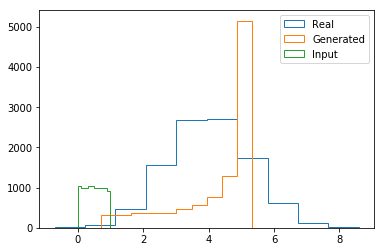

Stage 162 (Epoch: 32400)
Mean and Std of Real: (4.0025993831562765, 1.2431249258401673)
Mean and Std of Gen: (4.439978, 1.1660239)


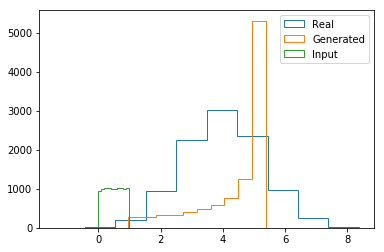

Stage 163 (Epoch: 32600)
Mean and Std of Real: (3.9910275903824766, 1.2352664162234626)
Mean and Std of Gen: (4.535554, 1.2606559)


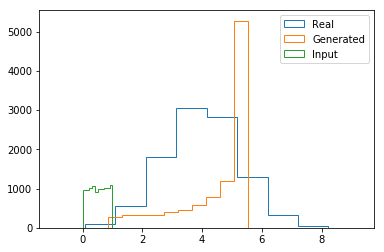

Stage 164 (Epoch: 32800)
Mean and Std of Real: (4.003103451291564, 1.2541423430468845)
Mean and Std of Gen: (3.8391461, 1.2925155)


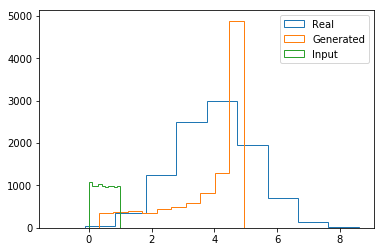

Stage 165 (Epoch: 33000)
Mean and Std of Real: (3.9936890907146734, 1.2328996947527884)
Mean and Std of Gen: (3.957938, 1.2741795)


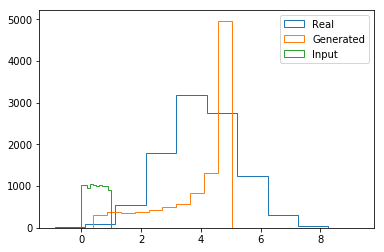

Stage 166 (Epoch: 33200)
Mean and Std of Real: (3.9931628020575314, 1.2359752011365113)
Mean and Std of Gen: (4.708582, 1.2461522)


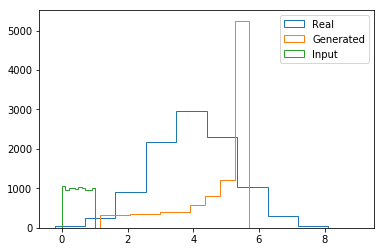

Stage 167 (Epoch: 33400)
Mean and Std of Real: (4.020069506003397, 1.2613074789834986)
Mean and Std of Gen: (4.6077466, 1.0967174)


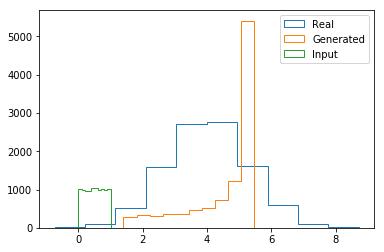

Stage 168 (Epoch: 33600)
Mean and Std of Real: (4.004532342198586, 1.2355806772336777)
Mean and Std of Gen: (4.429682, 1.2988094)


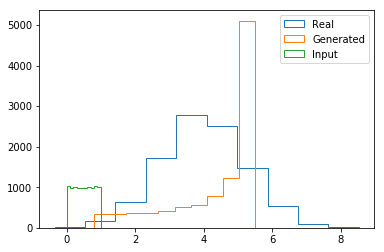

Stage 169 (Epoch: 33800)
Mean and Std of Real: (3.9816119623186212, 1.252499876195987)
Mean and Std of Gen: (3.565614, 1.0332184)


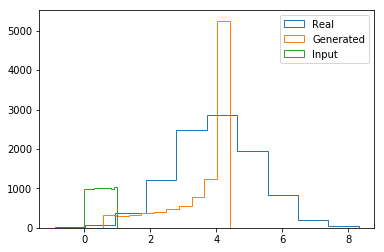

Stage 170 (Epoch: 34000)
Mean and Std of Real: (4.013714579300952, 1.2513495249928894)
Mean and Std of Gen: (3.4244726, 1.1270894)


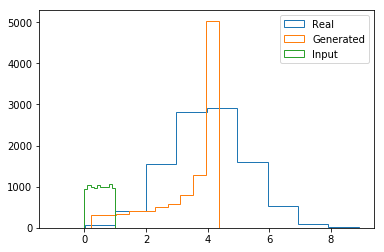

Stage 171 (Epoch: 34200)
Mean and Std of Real: (4.004422600789567, 1.2416275673702697)
Mean and Std of Gen: (3.2130787, 1.4487092)


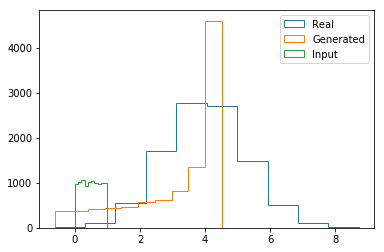

Stage 172 (Epoch: 34400)
Mean and Std of Real: (4.017953042803048, 1.2537314094208392)
Mean and Std of Gen: (4.021101, 1.3004736)


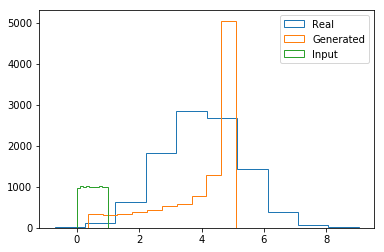

Stage 173 (Epoch: 34600)
Mean and Std of Real: (3.998205244359607, 1.2404708770020825)
Mean and Std of Gen: (4.560766, 1.2405005)


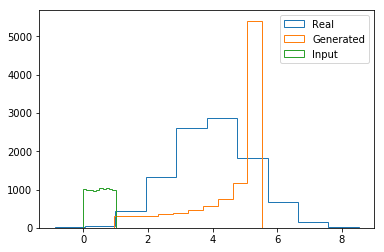

Stage 174 (Epoch: 34800)
Mean and Std of Real: (4.018994814325846, 1.2367220357443915)
Mean and Std of Gen: (3.8916383, 1.1518869)


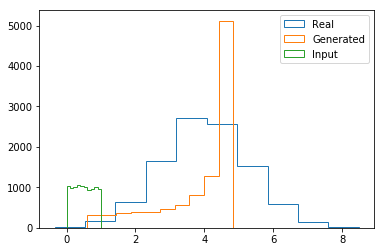

Stage 175 (Epoch: 35000)
Mean and Std of Real: (3.9926611670408754, 1.24709838028455)
Mean and Std of Gen: (4.1383033, 1.3970641)


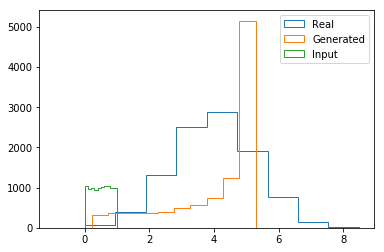

Stage 176 (Epoch: 35200)
Mean and Std of Real: (4.010968336230728, 1.247137560745253)
Mean and Std of Gen: (3.4986563, 1.1786331)


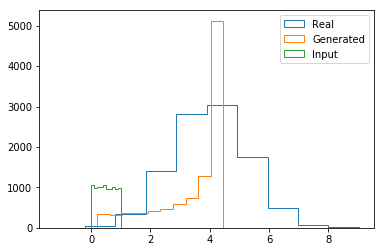

Stage 177 (Epoch: 35400)
Mean and Std of Real: (3.983333637338512, 1.2526464447521477)
Mean and Std of Gen: (4.4740243, 1.304916)


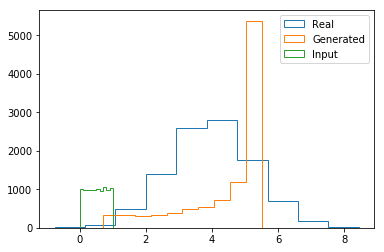

Stage 178 (Epoch: 35600)
Mean and Std of Real: (4.020555679745235, 1.2581546664800611)
Mean and Std of Gen: (4.65765, 0.9926623)


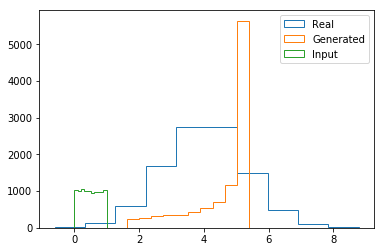

Stage 179 (Epoch: 35800)
Mean and Std of Real: (3.983489769888046, 1.2491202615073123)
Mean and Std of Gen: (4.155743, 1.3640827)


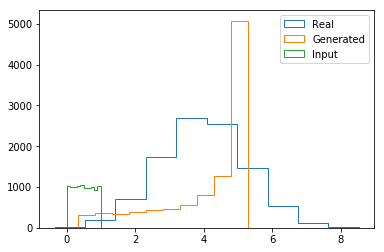

Stage 180 (Epoch: 36000)
Mean and Std of Real: (4.037179892881337, 1.2450517137831156)
Mean and Std of Gen: (3.6414046, 1.3263303)


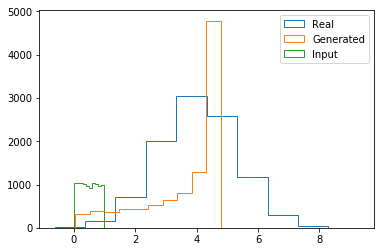

Stage 181 (Epoch: 36200)
Mean and Std of Real: (4.0257452895393895, 1.251475664981986)
Mean and Std of Gen: (4.555388, 1.2806827)


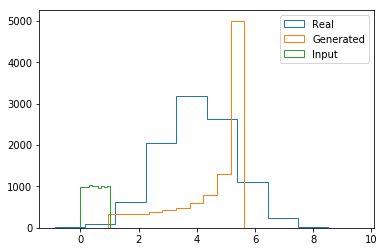

Stage 182 (Epoch: 36400)
Mean and Std of Real: (4.007228885911992, 1.2594606582182999)
Mean and Std of Gen: (3.4944992, 0.9841837)


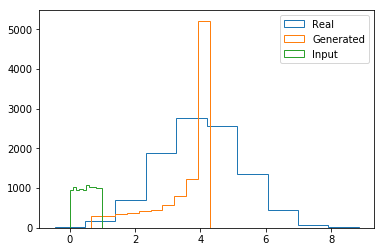

Stage 183 (Epoch: 36600)
Mean and Std of Real: (3.993239223391942, 1.2585574674174198)
Mean and Std of Gen: (4.3196893, 1.375079)


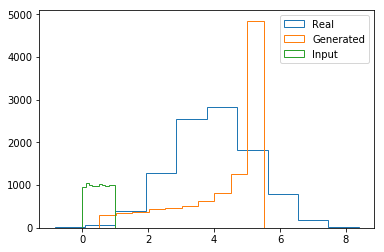

Stage 184 (Epoch: 36800)
Mean and Std of Real: (3.993913325611481, 1.2581741090312188)
Mean and Std of Gen: (4.260116, 1.13254)


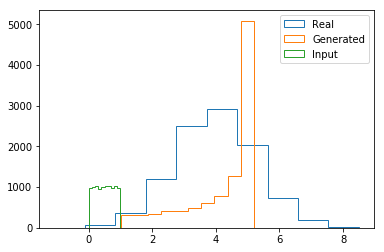

Stage 185 (Epoch: 37000)
Mean and Std of Real: (3.999965483233262, 1.260350340487175)
Mean and Std of Gen: (4.429726, 1.2760109)


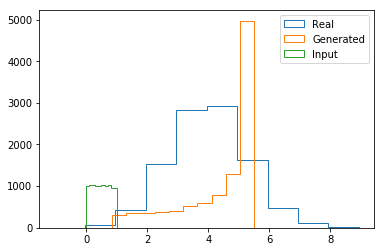

Stage 186 (Epoch: 37200)
Mean and Std of Real: (4.000660125913068, 1.2524093072676858)
Mean and Std of Gen: (3.7869024, 1.1628906)


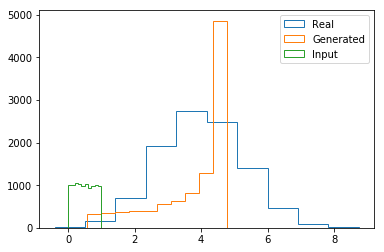

Stage 187 (Epoch: 37400)
Mean and Std of Real: (3.9983243240258353, 1.248207359208099)
Mean and Std of Gen: (3.5416243, 1.3653243)


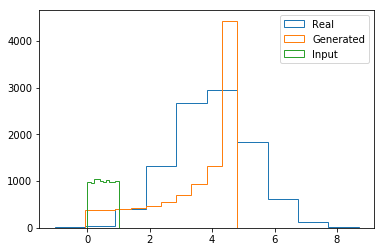

Stage 188 (Epoch: 37600)
Mean and Std of Real: (4.013988430997022, 1.262922201873203)
Mean and Std of Gen: (4.924518, 1.1375746)


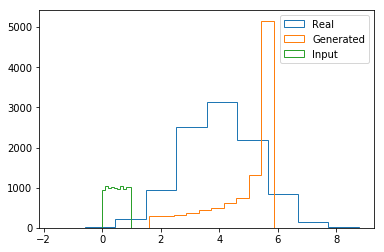

Stage 189 (Epoch: 37800)
Mean and Std of Real: (3.9882721588415575, 1.2476863094126465)
Mean and Std of Gen: (3.8942297, 1.1249493)


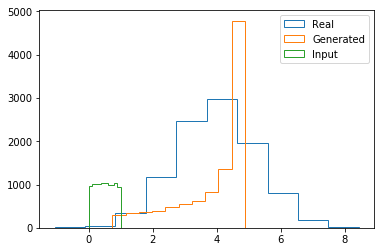

Stage 190 (Epoch: 38000)
Mean and Std of Real: (4.01055594983129, 1.2428415606395828)
Mean and Std of Gen: (3.700968, 1.4562781)


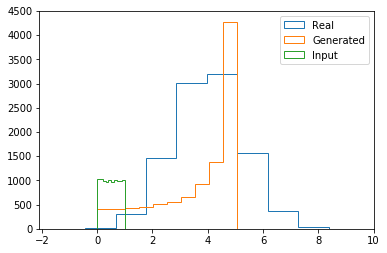

Stage 191 (Epoch: 38200)
Mean and Std of Real: (3.9683373536022963, 1.2424376727950759)
Mean and Std of Gen: (3.1549542, 1.1331052)


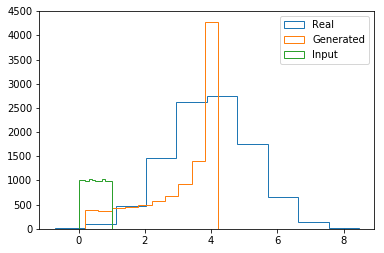

Stage 192 (Epoch: 38400)
Mean and Std of Real: (3.993013369283267, 1.2595509724129816)
Mean and Std of Gen: (4.527804, 1.1490026)


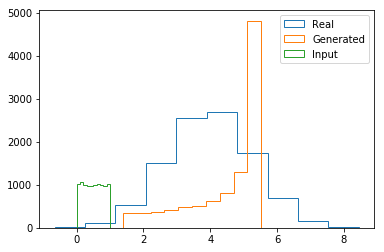

Stage 193 (Epoch: 38600)
Mean and Std of Real: (3.983570165212577, 1.237122110311626)
Mean and Std of Gen: (3.5608344, 1.2365803)


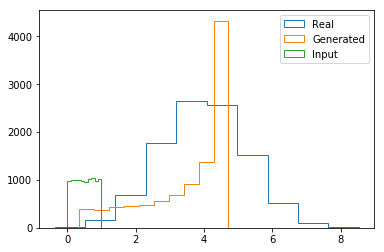

Stage 194 (Epoch: 38800)
Mean and Std of Real: (3.9839402656257654, 1.2530189340749815)
Mean and Std of Gen: (4.742085, 1.3542185)


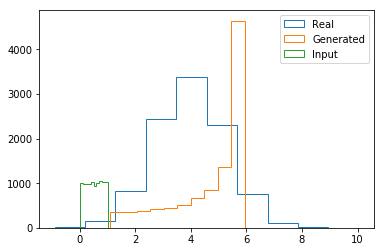

Stage 195 (Epoch: 39000)
Mean and Std of Real: (3.9886197832406345, 1.2531373399194554)
Mean and Std of Gen: (3.436469, 0.96314687)


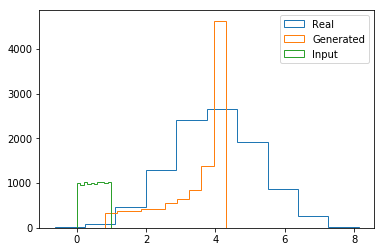

Stage 196 (Epoch: 39200)
Mean and Std of Real: (4.007184648367442, 1.2389875473100371)
Mean and Std of Gen: (4.675172, 1.2677659)


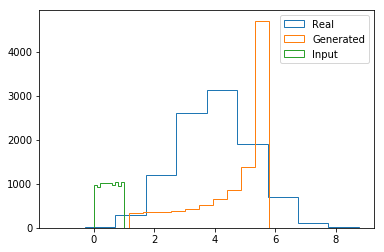

Stage 197 (Epoch: 39400)
Mean and Std of Real: (3.976990086873457, 1.2438768927047774)
Mean and Std of Gen: (3.6258848, 1.3031031)


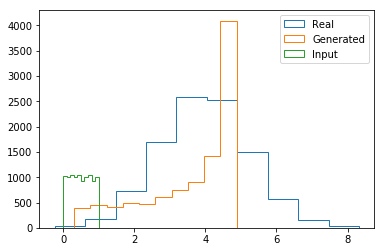

Stage 198 (Epoch: 39600)
Mean and Std of Real: (4.002841632213142, 1.2325619994551311)
Mean and Std of Gen: (3.2906406, 1.2140802)


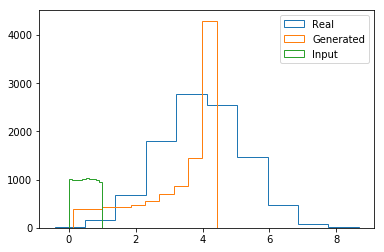

Stage 199 (Epoch: 39800)
Mean and Std of Real: (3.986788471493098, 1.2592126010008982)
Mean and Std of Gen: (5.081668, 1.1562618)


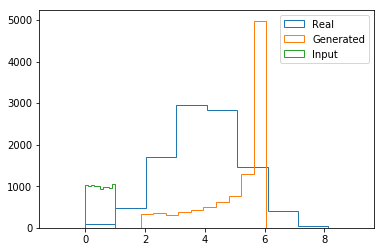

In [72]:
main()

In [4]:
real_sample = lambda n_batch: np.random.normal(4, 1.25, (n_batch, 100))

In [5]:
real_sample(1)

array([[3.03176604, 4.38481172, 3.89092615, 2.38223501, 4.84147091,
        5.54978007, 0.69236158, 3.72297457, 4.83506179, 6.3812466 ,
        4.99425978, 4.21388802, 3.75130963, 4.88945395, 3.43776848,
        3.70038717, 2.98278286, 4.61924152, 3.73936661, 4.50842032,
        4.26222458, 6.01363192, 3.79830779, 5.06986036, 3.29429154,
        4.78842465, 5.91559671, 3.34232823, 3.0317103 , 2.21423516,
        2.58322523, 4.31357318, 4.26452176, 4.16518086, 4.73195176,
        3.61605351, 3.14664103, 6.35642164, 5.73860371, 4.21398384,
        1.2282522 , 3.64658645, 2.72719993, 5.29714702, 3.16408339,
        3.26758316, 4.59721416, 1.99388293, 5.18377593, 4.22602484,
        4.01549768, 5.42989781, 3.5983266 , 3.5213028 , 1.85560193,
        5.81121125, 6.47729239, 2.84211022, 3.7788841 , 2.28966035,
        6.14659495, 2.9581311 , 3.87290564, 4.34832173, 6.09085647,
        1.42356613, 4.1874819 , 4.12886261, 4.19609768, 2.25220495,
        5.7930263 , 4.49100526, 4.52309225, 6.09

In [64]:
import os
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.datasets import cifar10
from keras import optimizers


def add_decorate(x):
    """
    axis = -1 --> last dimension in an array
    """
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)


learning_rate = 0.001

model = Sequential()
# model.add(Lambda(add_decorate, output_shape=None, input_shape=(100,)))
model.add(Dense(50, activation='relu', input_shape=(100,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

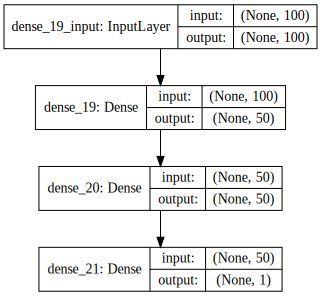

In [65]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
G = Sequential()
G = models.Sequential()  # (Batch, ni_D)
G.add(Reshape((100, 1), input_shape=(100,)))  # (Batch, steps=ni_D, input_dim=1)
G.add(Conv1D(50, 1, activation='relu'))  # (Batch, ni_D, nh_G)
G.add(Conv1D(50, 1, activation='sigmoid'))  # (Batch, ni_D, nh_G)
G.add(Conv1D(1, 1))  # (Batch, ni_D, 1)
G.add(Flatten())  # (Batch, ni_D)
optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)
G.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

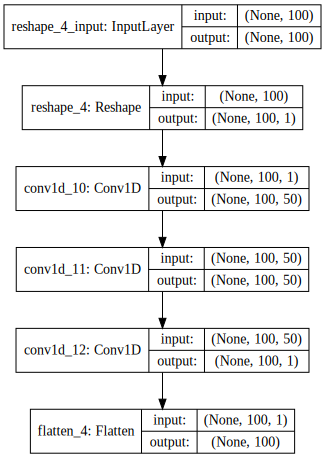

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(G, show_shapes=True).create(prog='dot', format='svg'))

## keras Backend K 함수의 사용법

In [42]:
b = K.random_uniform_variable(shape=(3, 4), low=0, high=1) # Uniform distribution
c = K.random_normal_variable(shape=(3, 4), mean=0, scale=1) # Gaussian distribution

# Tensor Arithmetic
a = K.concatenate([b, c], axis=-1)

In [43]:
b

<tf.Variable 'Variable_6:0' shape=(3, 4) dtype=float32_ref>

In [44]:
c

<tf.Variable 'Variable_7:0' shape=(3, 4) dtype=float32_ref>

In [45]:
a

<tf.Tensor 'concat_2:0' shape=(3, 8) dtype=float32>

#### np shape과의 비교를 통한 이해

In [35]:
y = np.zeros((3,4))
print(y)
print(y.shape)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [60]:
y = np.zeros((3,4))
x = np.zeros((3,3))
# y = np.zeros((3,4,2)) --> 이것도 됨
# x = np.zeros((3,4,5))

In [61]:
z = np.concatenate((y, x), axis=-1)

In [50]:
print(z)
print(z.shape)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
(3, 7)


In [63]:
y = np.zeros((4,3))
x = np.zeros((3,3))
# axis 0의 의미는 shape의 index의 의미. iterate하는 index 빼고는 모두 동일해야 함.
# y = np.zeros((4,3,1)) --> 됨
# x = np.zeros((3,3,1))
# y = np.zeros((4,3,1)) --> 안됨
# x = np.zeros((3,3,0))
z2 = np.concatenate((y, x), axis=0) 
print(z2)
print(z2.shape)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
(7, 3)
